In [4]:
import numpy as np
import os
import math
import matplotlib.pyplot as plt
%matplotlib inline

# Notes
1. Neural networks are just mathematical expressions.
2. Backpropagation is essentially applying the chain rule of calculus from the resulting value of an expression to get the derivative of the result w.r.t each of the variables in the expression.
3. In a NN, the expression is a function that takes the input data and weights of the neural network, and gives the prediction in terms of the loss function. We then do backpropagation (partial derivative of each of the weights of the NN w.r.t to the loss function) to get the gradient change direction and magnitude of the loss function as each weight variable changes. Using this information, we minimize the loss.
4. Backpropagation is general. We use it in a NN to get the gradients.
5. In a big neural network, all the weights are represented as tensors/arrays, but the math is the same. Because they are in these arrays, we can apply backpropagation to each of those values by taking advantage of the parallelism provided by GPUs.


In [5]:
def f(x):
    return 3*x**2 - 2*x - 1

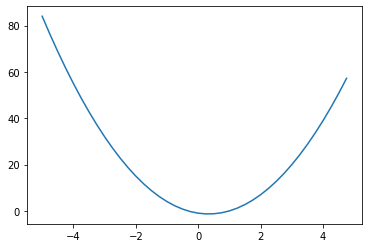

In [6]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)

In [7]:
# Derivative of f(x)
h = 0.001
x=3
dh = (f(x+h)-f(x))/h
dh

16.00300000000132

In [8]:
# Another f(x)
def f(a,b,c):
    return a*b+c


In [9]:
h = 0.00001
a = 2
b = -3
c = 10

y = f(a,b,c)
print("y: ", y)

#dy/da
dya = (f(a+h,b,c) - f(a,b,c))/h
print("dya: ", dya)

#dy/db
dyb = (f(a,b+h,c) - f(a,b,c))/h
print("dyb: ", dyb)


y:  4
dya:  -3.000000000064062
dyb:  2.0000000000131024


## For Neural networks, the expressions are massive. So we need a data structure to store those expressions and evaluate their derivates

In [21]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = _children
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data}, label={self.label})"
        
    def __add__(self, other):
        return Value(self.data + other.data, (self, other), '+')
    
    def __sub__(self, other):
        return Value(self.data - other.data, (self, other), '-')
    
    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), '*')

    def __div__(self, other):
        return Value(self.data / other.data, (self, other), '/')
    
    def __pow__(self, other):
        return Value(self.data ** other.data, (self, other), '**')
    

In [26]:
# Representing same above expression in the Value DS
a = Value(2, label='a')
b = Value(-3, label='b')
c = Value(10, label='c')

e = a*b; e.label='e'
y = e + c # Equivalent to a.__mul__(b).__add__(c)
y.label = 'y'
y, y._prev, y._op, y._prev[0]._prev, y._prev[0]._op

(Value(data=4, label=y),
 (Value(data=-6, label=e), Value(data=10, label=c)),
 '+',
 (Value(data=2, label=a), Value(data=-3, label=b)),
 '*')

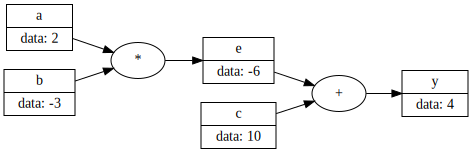

In [33]:
# Representing this expression as a graph

from graphviz import Digraph

def build(vertex, nodes, edges):
    if vertex not in nodes:
        nodes.add(vertex)
        for child in vertex._prev:
            edges.add((child, vertex))
            build(child, nodes, edges)


def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    build(root, nodes, edges)
    
    return nodes, edges
    

def draw_graph(root):
    graph = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    
    for node in nodes:
        uid = str(id(node))
        
        if hasattr(node, "grad"):
            graph.node(name=uid, label = f"{node.label} | data: {node.data} | grad: {node.grad}", shape='record')
        else:
            graph.node(name=uid, label = f"{node.label} | data: {node.data}", shape='record')
            
        if node._op:
            graph.node(name = uid + node._op, label = node._op)
            graph.edge(uid+node._op, uid)
        
    for node1, node2 in edges:
        graph.edge(str(id(node1)), str(id(node2)) + node2._op)
        
    return graph

        
draw_graph(y)

In [34]:
# Representing another expression in the Value DS
a = Value(2, label='a')
b = Value(-3, label='b')
c = Value(10, label='c')

e = a*b; e.label='e'
d = e + c; d.label = 'd'
f = Value(-2, label='f')
L = f*d; L.label='L'
L

Value(data=-8, label=L)

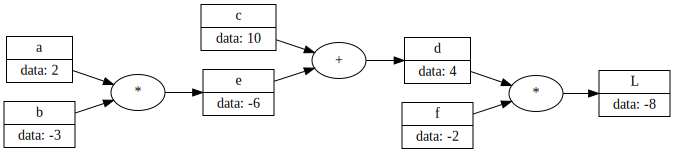

In [35]:
draw_graph(L)

## Now we need to calculate the derivative of L w.r.t each node for every node
### Eg dL/df, dL/de etc.

These nodes will eventually represent the weights of the neural network. So by doing backpropagation we know how the change in each of these weights is affecting the loss function. We can use this information to minimize the loss.
So essentially we need d(output)/d(weights) for all weights
We usually dont take derivative of the input because inputs are usually fixed and weights are trained

In [41]:
np.isscalar(f)

False

In [58]:
# Rewriting Value with gradient calculation
import numpy as np
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = _children
        self.grad = 0.0
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data}, label={self.label})"
        
    def __add__(self, other):
        if np.isscalar(other):
            return Value(self.data + other, (self, other), '+')
        else:
            return Value(self.data + other.data, (self, other), '+')
    
    def __sub__(self, other):
        return Value(self.data - other.data, (self, other), '-')
    
    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), '*')

    def __truediv__(self, other):
        if np.isscalar(other):
            return Value(self.data / other, (self, other), '/')
        else:
            return Value(self.data / other.data, (self, other), '/')
    
    def __pow__(self, other):
        return Value(self.data ** other.data, (self, other), '**')
    

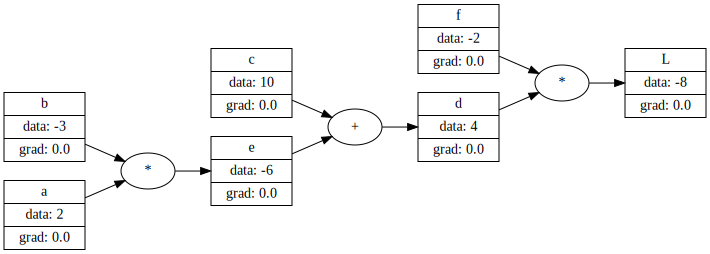

In [90]:
# Representing another expression in the Value DS
a = Value(2, label='a')
b = Value(-3, label='b')
c = Value(10, label='c')

e = a*b; e.label='e'
d = e + c; d.label = 'd'
f = Value(-2, label='f')
L = f*d; L.label='L'
draw_graph(L)

In [67]:
# Numberical gradient calculationg of each variable w.r.t L
h=0.00001

a = Value(2, label='a')
b = Value(-3, label='b')
c = Value(10, label='c')

e = a*b; e.label='e'
d = e + c; d.label = 'd'
f = Value(-2, label='f')
L1 = f*d; L.label='L1'

a = Value(2, label='a')
b = Value(-3, label='b')
c = Value(10, label='c')

e = a*b; e.label='e'
e=e+h
d = e + c; d.label = 'd'
f = Value(-2, label='f')

L2 = f*d; L.label='L2'

(L2-L1)/h

Value(data=-1.9999999999242843, label=)

In [91]:
# Manually filling gradients by evaluating chain rule
L.grad = 1 # dL/dL
f.grad = 4 # dL/df = d(f*d)/df = d
d.grad = -2 # dL/dd = d(f*d)/dd = f
c.grad = -2 # dL/dc = (dL/dd)*(dd/dc) = -2 * d(e+c)/dc = -2 * 1 = -2
e.grad = -2 # dL/de = (dL/dd)*(dd/de) = -2 * d(e+c)/de = -2 * 1 = -2
b.grad = -4 # dL/db = (dL/de)*(de/db) = -2 * d(a*b)/db = -2 * a = -2 * 2 = -4
a.grad = 6 # dL/da = (dL/de)*(de/da) = -2 * d(a*b)/da = -2 * b = -2 * -3 = 6

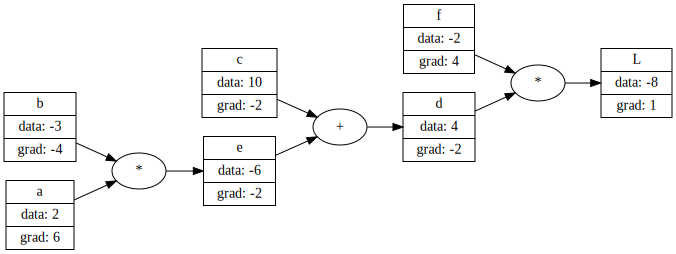

In [92]:
draw_graph(L)

## Backpropagation
### Essentially chain rule of calculus applied recursively through the computational graph from output to input (backwards)

### Loss function is reduced by changing the values along the gradients

In [93]:
# Loss updated by updating the values along the gradients
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a*b
d = e + c
L = f*d

L.data

-7.286496